# Gradient Boost (XGBoost)
El *Gradient boosting* es uno de los métodos predominantes para construir y optimizar modelos.

Consiste en ensamblar varios árboles de decisión (de manera similar al RandomForest) pero con un criterio basado en el error actual del Modelo. Es decir, se realizan iteraciones, en las cuales se agrega un árbol de manera tal que el error disminuya respecto de la iteración anterior. 

Es como una manera de agregar árboles "inteligentemente" (buscando disminuir el error, mejorando la eficacia del ensamble en cada iteración).

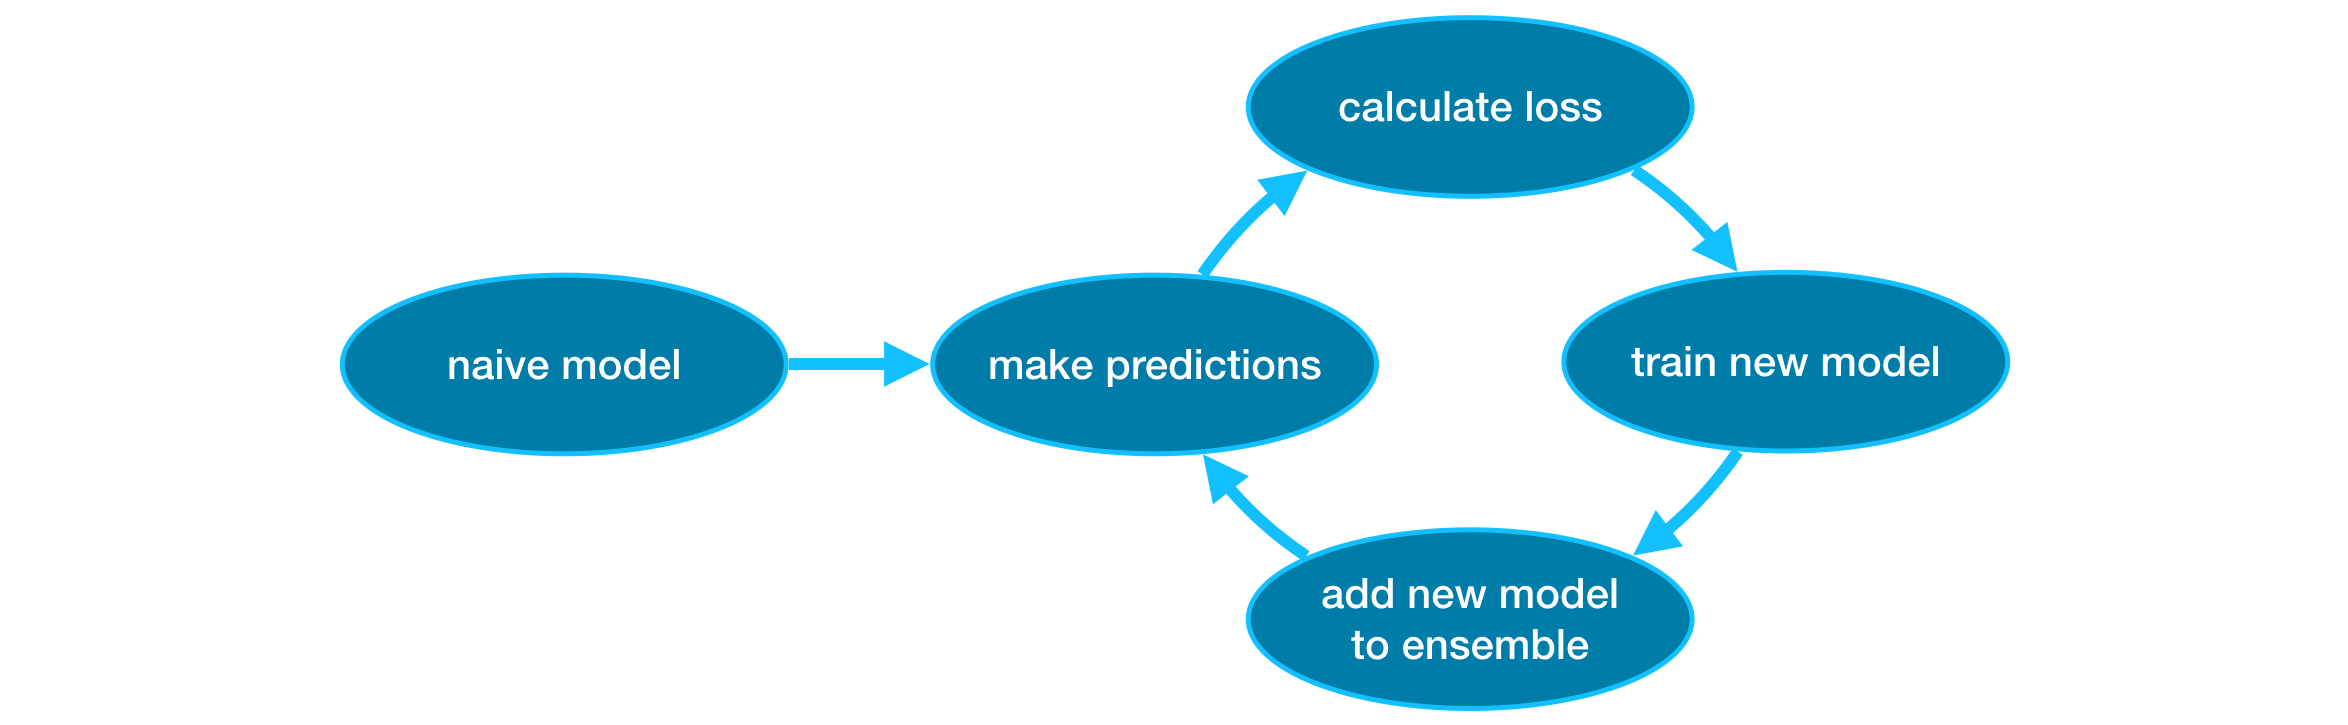

## Parámetros más importantes
Este modelo cuenta con parámetros que, al modificarlos, pueden **mejorar sustancialmente su eficacia y velocidad.**
- **n_estimators:** número de modelos que incluirá. Un valor muy bajo puede provar *underfitting*, mientras que uno muy alto *overfitting*. Valores típicos pueden rondar entre 100 y 1000, aunque dependerá, también, del valor de *learning_rate*.
- **early_stopping_rounds:** ofrece la posibilidad de encontrar automáticamente el valor ideal de *n_estimators*. Permitirá que el modelo deje de iterar (y agregar estimadores) cuando la medida de *validation_score* deje de mejorar. Teniendo en cuenta que hay cierto azar en esta medida, y pudiendo el *score* empeorar de un paso al otro, se utiliza este parámetro para indicar cuántas iteraciones seguidas sin mejora deben presentarse para que la iteración cese. Es inteligente utilizar un alto *n_estimators* y dejar que *early_stopping* trabaje de manera de encontrar automáticamente el mejor valor de estimadores. Se deberá separar un set de validactión (parámetro *eval_set* de *model.fit*)
- **learning_rate:** cada predicción incorporada se multiplica por un valor pequeño, de tal manera que su influencia disminuirá en función de su orden dentro de las iteraciones. Permite utilizar un *n_estimators* alto, sin causar *overfitting*, pero tener en cuenta que su tiempo de ejecución también será más alto.
- **n_jobs:** permite utilizar paralelismo para extensos datasets, donde el tiempo de ejecución puede ser muy alto. Es común setear el valor igual al número de núcleos que tenga la máquina.


## Ejercicios Prácticos
Comenzamos con el uso básico del XGBRegressor y vemos cómo varía la performance del modelo.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('assets/input/train.csv', index_col='Id')
test_data = pd.read_csv('assets/input/test.csv',  index_col='Id') 

train_data.dropna(subset=['SalePrice'], axis=0, inplace=True)
y = train_data.SalePrice
X = train_data.drop('SalePrice', axis=1)

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# selecciono columnas y codifico categoricas
numeric_cols = [col for col in train_X.columns if train_X[col].dtype in ['float64', 'int64']]
low_cardinality_cols = [col for col in train_X.columns 
                            if train_X[col].dtype == 'object' and 
                               train_X[col].nunique() < 10
                       ]

cols_to_use = numeric_cols + low_cardinality_cols
train_X = train_X[cols_to_use].copy()
val_X = val_X[cols_to_use].copy()
test_X = test_data[cols_to_use].copy()

# esto es como una forma simple de hacer la codificacion
# no la explicaba (VER dsp)
train_X = pd.get_dummies(train_X)
val_X = pd.get_dummies(val_X)
test_X = pd.get_dummies(test_X)
train_X, val_X = train_X.align(val_X, join='left', axis=1)
train_X, test_X = train_X.align(test_X, join='left', axis=1)

print('Listo')

Listo


In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

model = XGBRegressor(random_state=0)
model.fit(train_X, train_y)

preds = model.predict(val_X)
mae = mean_absolute_error(val_y, preds)

print('MAE XGBRegressor (básico): {:.0f}'.format(mae))

C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MAE XGBRegressor (básico): 17663


## Primeros comentarios
Podemos ver, inicialmente, que **sin haber configurado ningún parámetr**o e incluso con un **preprocesamiento muy básico**, el modelo ya presenta un **buen rendimiento**. 

## Mejoras
Ahora, modificaremos sus parámetros para ver cómo afecta su eficacia.


In [31]:
# modificacion parametros n_estimators, learning_rate
model = XGBRegressor(n_estimators=500, learning_rate=0.05)

model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(val_X, val_y)], verbose=False)
preds = model.predict(val_X)
mae = mean_absolute_error(val_y, preds)

print('MAE XGBRegressor (estimators=500, learning_rate=0.05): {:.0f}'.format(mae))

C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MAE XGBRegressor (estimators=500, learning_rate=0.05): 16689


**Nuevamente, se observa una mejora. El modelo ya está dando resultados mejores que los obtenidos hasta aquí con RandomForest, casi sin tener que preprocesar sus datos y con dos simples parámetros.**

**NOTA:** Inicialmente había ejecutado *fit* sin los parámetros de *early_stopping* y había obtenido *MAE=16728*, luego, al colocarlos se fue a *MAE=16803*, esto **no se bien por qué**. Quizás tenía que ver con que se producía overfitting (ya que tenía un n_estimators "alto" de 500 (por ahí, el early_stopping, corta antes que comience el overfitting con una cantidad menor de estimadores).

## Pruebas con varios modelos
A continuación, realizo pruebas con varios valores para los parámetros, intentando encontrar el que mejor performance entregue.

**OJO:** Hice una sola vez una prueba iterativa de muchos n_est/learning_rate pero no conviene hacerlo porque tarda MUCHO. Por eso debe ser que en la práctica sugerían probar valores al azar directamente.


In [38]:
def model_score(n_est, learning_rate):
    model = XGBRegressor(n_estimators=n_est, learning_rate=learning_rate)
    model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(val_X, val_y)], verbose=False)
    preds = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds)
    return mae

cand_estimators = range(100, 1000, 100)
cand_learn_rate = range(1, 10, 1) # centesimas

results = {}
for n_est in cand_estimators:
    est_results = [model_score(n_est, lr/100) for lr in cand_learn_rate]
    results[n_est] = est_results

C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning:

C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning:

C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\livra\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning:

{100: [68584.80573095035,
  29190.75549818065,
  19464.58728863442,
  17917.162858518837,
  17213.82253317637,
  17157.53499571918,
  17502.735418450342,
  17351.477472174658,
  16754.28151755137],
 200: [29111.517725278252,
  17953.71944563356,
  17119.91956068065,
  17319.79377140411,
  16833.69044306507,
  17021.28149079623,
  17295.470770012842,
  17356.075824058218,
  16716.22032855308],
 300: [19659.72196061644,
  17232.937834439213,
  16994.724823416094,
  17319.79377140411,
  16802.965325342466,
  17021.28149079623,
  17295.470770012842,
  17356.075824058218,
  16716.22032855308],
 400: [17840.48311750856,
  17061.732234589042,
  16922.81834599743,
  17319.79377140411,
  16802.965325342466,
  17021.28149079623,
  17295.470770012842,
  17356.075824058218,
  16716.22032855308],
 500: [17287.811055222603,
  17028.056747645547,
  16922.81834599743,
  17319.79377140411,
  16802.965325342466,
  17021.28149079623,
  17295.470770012842,
  17356.075824058218,
  16716.22032855308],
 600:

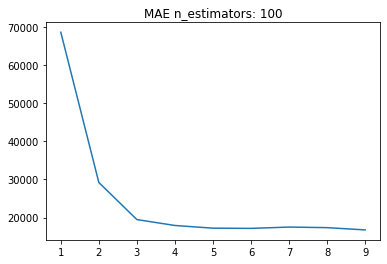

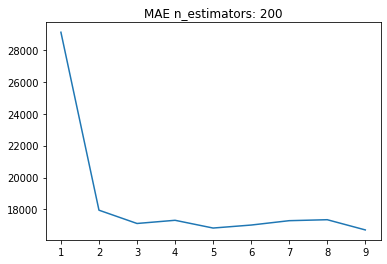

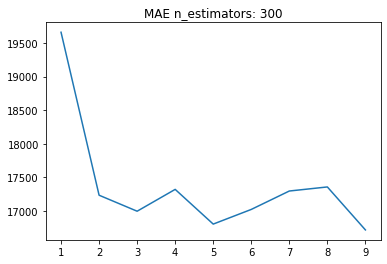

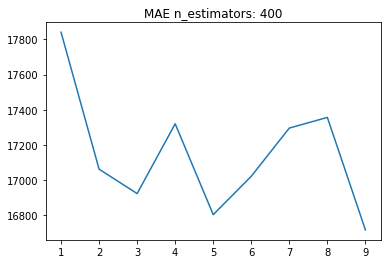

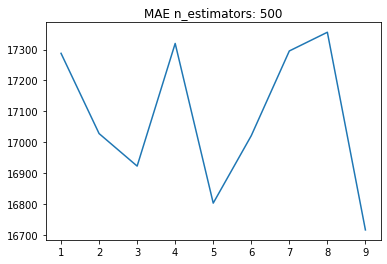

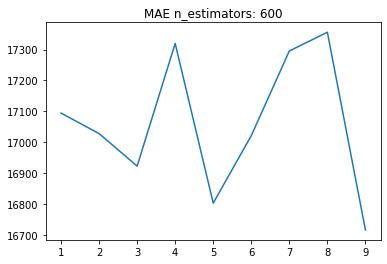

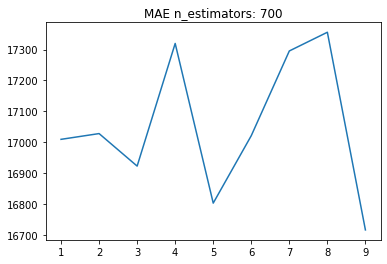

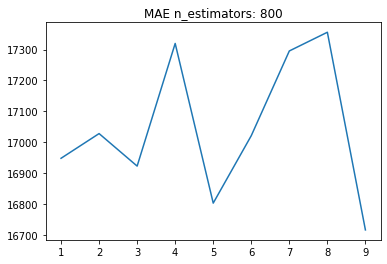

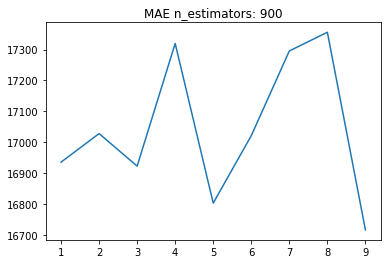

In [54]:
# ya que me tome el tiempo, analizo graficamente
import matplotlib.pyplot as plt
%matplotlib inline

for n_est, mae_by_learning_rate in results.items():
    plt.title('MAE n_estimators: '+str(n_est))
    plt.plot(range(1,10), mae_by_learning_rate)
    plt.show()

In [58]:
# mejor valor de mae segun learning_rate para cada n_estimators
# filtro result hasta el lr=0.06 xq creo q dsp esta metiendo overfitting
best_lr_by_estimators = {n_est: min(results[n_est][:7]) for n_est in results}
best_lr_by_estimators

{100: 17157.53499571918,
 200: 16833.69044306507,
 300: 16802.965325342466,
 400: 16802.965325342466,
 500: 16802.965325342466,
 600: 16802.965325342466,
 700: 16802.965325342466,
 800: 16802.965325342466,
 900: 16802.965325342466}

## Conclusiones
Es como que **a partir de 200/300 estimadores**, el modelo ya no mejora, y obtiene su **mejor performance con un learning_rate=0.05.**

## Aplico lo aprendido en Competencia
Teniendo en cuenta lo aprendido, trato de mejorar mi modelo de manera tal de obtener una mejor performance en la competencia de *House Pricing*

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

train_data = pd.read_csv('assets/input/train.csv', index_col='Id')
test_data = pd.read_csv('assets/input/test.csv',  index_col='Id') 

train_data.dropna(subset=['SalePrice'], axis=0, inplace=True)
y = train_data.SalePrice
X = train_data.drop('SalePrice', axis=1)

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# al usar OrdinalEncoder con handle_unknown no necesito filtrar Variables Catergoricas 
# ni por Cardinalidad (OneHot) 
# ni por subset (valores que no estan en el entrenamiento y si en la prediccion)
# Pero esto es necesario para el pipeline nomas (como dije no filtro nada)
num_cols = [col for col in X_full.columns if X_full[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in X_full.columns if X_full[col].dtype == 'object' ]

# Preprocesamiento
num_transformer = SimpleImputer(strategy='median')
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

print('setup listo')

setup listo


In [94]:
# from sklearn.ensemble import RandomForestRegressor
# model = XGBRegressor(n_estimators=300, learning_rate=0.05) # este era el mejor supuestamente
model = XGBRegressor(n_estimators=300, learning_rate=0.03) # pero este anduvo mejor
model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

model_pipe.fit(train_X, train_y)
train_preds = model_pipe.predict(val_X)
train_mae = mean_absolute_error(val_y, train_preds)
print('MAE (training XGBRegressor for competition): {:.0f}'.format(train_mae))

MAE (training XGBRegressor for competition): 16828


### Dudas
- Me esta dando peor que con RandomForest (17150)
- que onda xgbregressor y pipeline tema fit
- que onda xgbregressor y crossvalidation (porq en fit ya hace la validation en teoria, justamente es la gracia del xgboost)


Igualmente, pruebo con datos de la competencia (*test.csv*) a ver si me da peor o no.

In [96]:
# el preprocessor se ejecutara en pipe.predict
# uso todas las columnas (no filtre ninguna en training)
test_X = test_data

# entreno el modelo con data total
model_pipe.fit(X, y)
test_preds = model_pipe.predict(test_X)

output = pd.DataFrame({'Id': test_X.index, 'SalePrice': test_preds})
output.to_csv('assets/output/home_submission_xgb.csv', index=False)

## Conclusiones - Dudas
Finalmente, aunque en principio el resultado que se suponía debía ser mejor que el obtenido en clases anteriores (con modelo RandomForest) era peor al realizar el cálculo del MAE (17200 vs 17100), al utilizarlo sobre la data de la competencia terminaba arrojando un mejor resultado (mejor score en la competencia).

Por otro lado, analizando variantes al modelo (n_estimators, learning_rate) aunque se suponía que ya había encontrado el mejor XGBRegressor, por los gráficos que había realizado analizando el error en función de los parámetros, modifiqué los mismos y obtuve un modelo con mejor rendimiento.